# TikTok-Style Recommendation Analytics & A/B Experimentation

## Import Required Libraries

In [2]:

# Core Data Handling

import numpy as np
import pandas as pd


# Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Statistics & A/B Testing

from scipy.stats import ttest_ind


# Reproducibility

np.random.seed(42)


# Display Settings

pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")


## Synthetic Dataset Generation

In [3]:
# Global parameters

N_USERS = 3000
N_VIDEOS = 1200
N_CREATORS = 300
N_TOPICS = 8
N_INTERACTIONS = 180_000

np.random.seed(42)

# Topics Name

topics = [
    
    "Comedy","Music", "Sports", "Gaming","Education","Lifestyle","News","Tech"
]





In [4]:
# Users → Topic Preferences

user_prefs = np.random.dirichlet(alpha=[0.8] * N_TOPICS, size = N_USERS)

In [5]:
# Videos → Topics + Length
video_topics = np.random.choice(N_TOPICS,N_VIDEOS)
video_lengths = np.random.randint(15,90,size = N_VIDEOS)

In [6]:
video_topics

array([3, 4, 7, ..., 0, 0, 2])

In [7]:
video_lengths

array([47, 44, 36, ..., 73, 73, 57])

In [8]:
# Creators → Specialization

creator_topics = np.random.choice(N_TOPICS, N_CREATORS)
video_creators = np.random.choice(N_CREATORS, N_VIDEOS)

In [9]:
# Generate Interactions


records = []

for _ in range(N_INTERACTIONS):
    user = np.random.randint(N_USERS)
    video = np.random.randint(N_VIDEOS)
    
    topic = video_topics[video]
    base_interest = user_prefs[user,topic]
    
    noise = np.random.normal(0,0.1)
    watch_fraction= np.clip(base_interest + noise, 0.05,1.0)
    
    watch_time = watch_fraction * video_lengths[video]
    
    
    records.append({
        
        "user_id" : user,
        "video_id": video,
        "creator_id": video_creators[video],
        "topic":topic,
        "video_length":video_lengths[video],
        "watch_time": watch_time,
        "completion_rate": watch_fraction,
        "likes": int(watch_fraction > 0.65),
        "shares": int(watch_fraction >0.8),
        "follows": int(watch_fraction > 0.9)
    
        
    })
    

In [10]:
records[0]

{'user_id': 2559,
 'video_id': 400,
 'creator_id': 252,
 'topic': 0,
 'video_length': 32,
 'watch_time': 1.6,
 'completion_rate': 0.05,
 'likes': 0,
 'shares': 0,
 'follows': 0}

In [11]:
df = pd.DataFrame(records)


In [12]:
df.head()

,user_id,video_id,creator_id,topic,video_length,watch_time,completion_rate,likes,shares,follows
0,2559,400,252,0,32,1.600000,0.050000,0,0,0
1,1702,644,37,0,34,8.042061,0.236531,0,0,0
2,78,620,230,7,77,3.850000,0.050000,0,0,0
3,1566,460,270,3,86,11.870592,0.138030,0,0,0
4,1063,799,234,2,21,3.336751,0.158893,0,0,0


In [13]:
df.describe()


,user_id,video_id,creator_id,topic,video_length,watch_time,completion_rate,likes,shares,follows
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000
mean,1497.038717,598.214533,147.786594,3.339956,51.851767,7.882182,0.152159,0.003828,0.000367,0.000044
std,865.920797,346.182453,86.330147,2.288610,21.264201,7.738903,0.125722,0.061751,0.019145,0.006667
min,0.000000,0.000000,0.000000,0.000000,15.000000,0.750000,0.050000,0.000000,0.000000,0.000000
25%,747.000000,298.000000,75.000000,1.000000,34.000000,2.800000,0.050000,0.000000,0.000000,0.000000
50%,1497.000000,598.000000,146.000000,3.000000,51.000000,4.625071,0.106806,0.000000,0.000000,0.000000
75%,2246.000000,897.000000,221.000000,5.000000,70.000000,10.538150,0.213415,0.000000,0.000000,0.000000
max,2999.000000,1199.000000,299.000000,7.000000,89.000000,75.293587,1.000000,1.000000,1.000000,1.000000


In [14]:
print("Unique users:", df.user_id.nunique())
print("Unique videos:", df.video_id.nunique())
print("Unique creators:", df.creator_id.nunique())


Unique users: 3000
Unique videos: 1200
Unique creators: 291


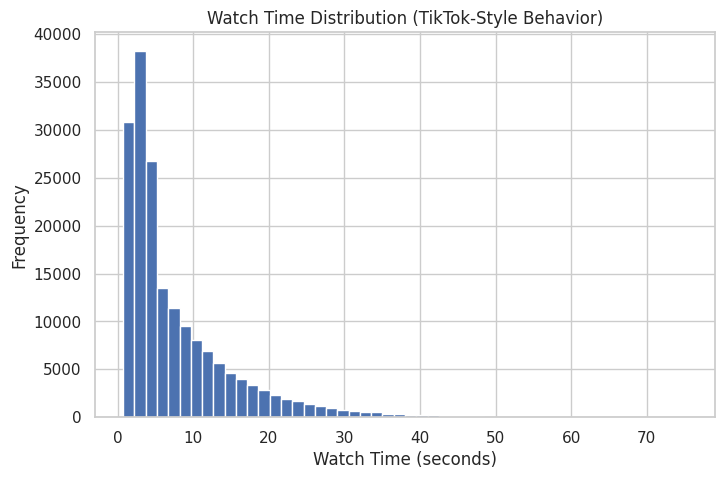

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(df["watch_time"], bins=50)
plt.title("Watch Time Distribution (TikTok-Style Behavior)")
plt.xlabel("Watch Time (seconds)")
plt.ylabel("Frequency")
plt.show()

# Engagement Score Engineering

* What Is an Engagement Score?

    A single number that represents how valuable an interaction was to the platform.

* Higher score → better recommendation signal.

In [16]:
print(
    "Signal            Why it matters\n"
    "Watch Time        Strong indicator of user interest\n"
    "Completion Rate   Reflects content quality\n"
    "Shares            Measures virality and reach\n"
    "Likes             Weak but useful explicit signal\n"
    "Follows           Indicates long-term user value"
)


Signal            Why it matters
Watch Time        Strong indicator of user interest
Completion Rate   Reflects content quality
Shares            Measures virality and reach
Likes             Weak but useful explicit signal
Follows           Indicates long-term user value


### Normalize Watch Time

In [17]:
df.columns

Index(['user_id', 'video_id', 'creator_id', 'topic', 'video_length',
       'watch_time', 'completion_rate', 'likes', 'shares', 'follows'],
      dtype='object')

In [18]:
df.watch_time

0          1.600000
1          8.042061
2          3.850000
3         11.870592
4          3.336751
            ...    
179995     1.700000
179996    14.454122
179997     1.350000
179998    11.733004
179999     3.907845
Name: watch_time, Length: 180000, dtype: float64

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()



In [20]:
df['watch_time_norm'] = scaler.fit_transform(df[['watch_time']])

In [21]:
df.watch_time_norm

0         0.011403
1         0.097823
2         0.041586
3         0.149182
4         0.034701
            ...   
179995    0.012744
179996    0.183840
179997    0.008049
179998    0.147337
179999    0.042362
Name: watch_time_norm, Length: 180000, dtype: float64

### Define Engagement Weight

In [22]:
W_WATCH = 0.45
W_COMPLETION = 0.30
W_SHARE = 0.15
W_LIKE = 0.10

`Why These Weights?`

* Watch time dominates revenue

* Completion reflects content strength

* Shares > likes (virality > vanity)

* Likes are weakest`

In [23]:
df['engagement_scores'] = (
    
    W_WATCH * df["watch_time_norm"] + 
    W_COMPLETION * df['completion_rate'] + 
    W_SHARE * df['shares'] + 
    W_LIKE * df['likes']                                  
)

In [24]:
df["engagement_scores"].describe()

count    180000.000000
mean          0.089141
std           0.083270
min           0.015000
25%           0.029488
50%           0.058379
75%           0.124147
max           0.977858
Name: engagement_scores, dtype: float64

## Interaction Matrix → Apply SVD

In [25]:
interaction_matrix = df.pivot_table(
    
    index = "user_id",
    columns= "video_id",
    values = "watch_time",
    aggfunc= "mean",
    fill_value = 0
    
)

In [26]:
interaction_matrix

video_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,8.96553,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3.378324,0.00,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,3.405985,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,16.773660,0.0,19.286271,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,15.605155,3.153752,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,3.084997,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,13.228794,0.0,0.000000
2,0.0,0.0,0.000000,7.583277,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.00,0.0,0.0,0.0,4.05,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,1.0,0.0,2.35,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,0.0,0.0,7.754404,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,6.620115,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,6.91515,0.0,0.000000,0.0,22.934576,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,0.00,0.000000,3.35,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,2.75,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,4.3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,0.00,19.390712,3.35,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,2.9,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,3.85,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.02191,0.0

In [27]:
interaction_matrix.shape

(3000, 1200)

In [28]:
# checking spacity

(interaction_matrix > 0).mean().mean() 

0.048759166666666666

### Truncated SVD

In [29]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(
    n_components = 30,
    random_state = 42
)

user_embeddings = svd.fit_transform(interaction_matrix)
video_embeddings = svd.components_.T


In [30]:
# Generate Personalized Score
import numpy as np
score_matrix = np.dot(user_embeddings, video_embeddings.T)


### Recomend Top k Videos for user

In [31]:
def recommend_videos(user_id,k = 10):
    scores = score_matrix[user_id]
    top_videos = np.argsort(scores)[-k:][::-1]
    return top_videos


In [32]:
recommend_videos(user_id = 42, k = 5)

array([762, 293,  90,  43, 781])

## A/B Experiment Setup

### Control (A): Popularity-Based Feed

In [33]:
popular_videos = (
 
    df.groupby("video_id")['watch_time']
               .mean()
                .sort_values(ascending = False)
                .index
                .values
                
)

In [34]:
def recommend_control(k = 10):
    return popular_videos[:k]

### Treatment (B): Personalized SVD Feed

In [35]:
def recommend_treatment(user_id, k = 10):
    scores = score_matrix[user_id]
    return scores.argsort()[-k:][::-1]


### Randomly Assign Users to A/B Groups

In [36]:
users = interaction_matrix.index.values

np.random.shuffle(users)

split = int(0.5 * len(users))
control_users = users[:split]
treatment_users = users[split:]

### Simulate Feed Exposure

In [37]:
def simulate_feed(user_id, group, k = 10):
    if group == 'control':
        return recommend_control(k)
    else:
        return recommend_treatment(user_id, k)

### Measure Metrics

In [38]:
def average_watch_time(user_ids, group):
    watch_times = []
    
    for u in user_ids:
        recs= simulate_feed(u,group)
        wt = df[
            (df.user_id == u) & (df.video_id.isin(recs))
        ]["watch_time"].mean()
        watch_times.append(wt)
        
    return np.nanmean(watch_times)            

### Compute A/B Results

In [39]:
control_wt = average_watch_time(control_users,"control")
treatment_wt = average_watch_time(treatment_users, "treatment")

uplift = (treatment_wt - control_wt) / control_wt * 100

control_wt, treatment_wt , uplift

(14.734923704109082, 22.347761777615077, 51.66526971146125)

### Statistical Significance (t-test)

In [40]:
def user_watch_time_on_feed(user_id, group):
    recs = simulate_feed(user_id, group)
    return df[
        (df.user_id == user_id) &
        (df.video_id.isin(recs))
    ]["watch_time"].mean()

control_vals = [
    user_watch_time_on_feed(u, "control")
    for u in control_users
]

treatment_vals = [
    user_watch_time_on_feed(u, "treatment")
    for u in treatment_users
]

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    treatment_vals,
    control_vals,
    nan_policy="omit"
)

p_value


2.4049013695309344e-55

## Visualize A/B Results (Control vs Treatment)

### Prepare Per-User Metrics (Same as t-test)

In [41]:
control_vals = [
    user_watch_time_on_feed(u, "control")
    for u in control_users
]

treatment_vals = [
    user_watch_time_on_feed(u, "treatment")
    for u in treatment_users
]


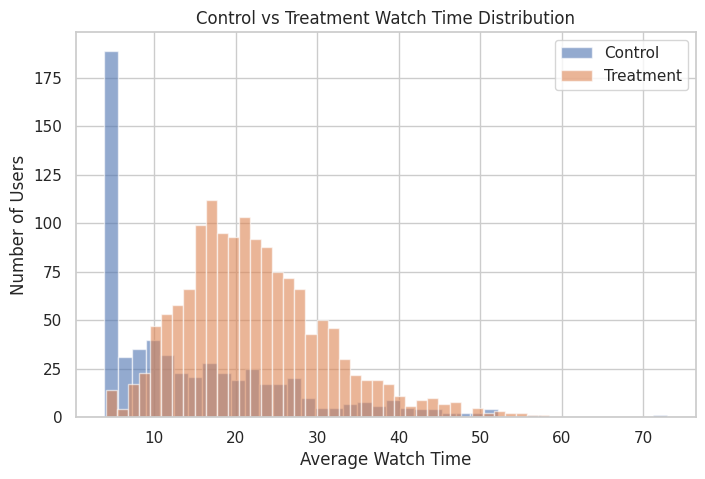

In [42]:


plt.figure(figsize=(8, 5))
plt.hist(control_vals, bins=40, alpha=0.6, label="Control")
plt.hist(treatment_vals, bins=40, alpha=0.6, label="Treatment")
plt.xlabel("Average Watch Time")
plt.ylabel("Number of Users")
plt.title("Control vs Treatment Watch Time Distribution")
plt.legend()
plt.show()


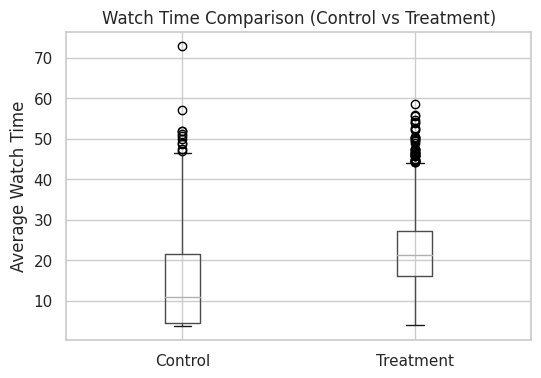

In [43]:


box_df = pd.DataFrame({
    "Control": control_vals,
    "Treatment": treatment_vals
})

box_df.boxplot(figsize=(6, 4))
plt.ylabel("Average Watch Time")
plt.title("Watch Time Comparison (Control vs Treatment)")
plt.show()


## Fairness Analysis (Creator Exposure)

###  Video → Creator Mapping

In [45]:
video_creator_map = (
    df[["video_id", "creator_id"]]
    .drop_duplicates()
)


In [46]:
def collect_creator_exposure(user_ids, group, k=10):
    exposure = []

    for u in user_ids:
        recs = simulate_feed(u, group, k)
        exposure.extend(recs)

    exposure_df = pd.DataFrame({"video_id": exposure})
    exposure_df = exposure_df.merge(
        video_creator_map,
        on="video_id",
        how="left"
    )

    return (
        exposure_df
        .groupby("creator_id")
        .size()
        .reset_index(name="exposure")
    )


In [47]:
control_exposure = collect_creator_exposure(
    control_users, "control"
)

treatment_exposure = collect_creator_exposure(
    treatment_users, "treatment"
)


In [48]:
import numpy as np

def gini(x):
    x = np.array(x)
    if np.sum(x) == 0:
        return 0
    x = np.sort(x)
    n = len(x)
    return (2 * np.sum((np.arange(1, n + 1) * x))) / (n * np.sum(x)) - (n + 1) / n


In [49]:
gini_control = gini(control_exposure["exposure"])
gini_treatment = gini(treatment_exposure["exposure"])

gini_control, gini_treatment


(0.0, 0.5445474074074075)

### Long-Tail Coverage (Very Important)

In [50]:
def long_tail_share(exposure_df):
    threshold = exposure_df["exposure"].quantile(0.8)
    return (
        exposure_df[exposure_df["exposure"] < threshold]["exposure"].sum()
        / exposure_df["exposure"].sum()
    )


In [51]:
lt_control = long_tail_share(control_exposure)
lt_treatment = long_tail_share(treatment_exposure)

lt_control, lt_treatment


(0.0, 0.4592)

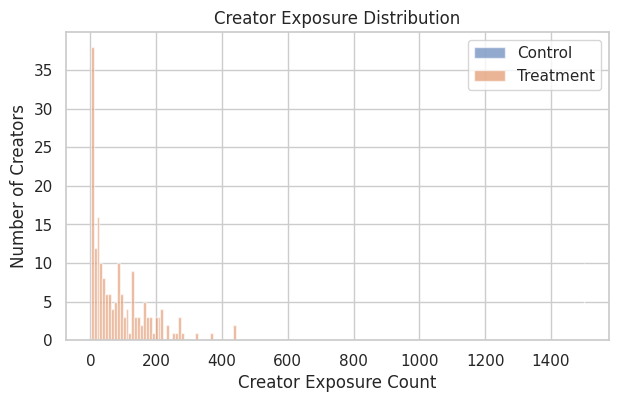

In [52]:
plt.figure(figsize=(7, 4))
plt.hist(
    control_exposure["exposure"],
    bins=50,
    alpha=0.6,
    label="Control"
)
plt.hist(
    treatment_exposure["exposure"],
    bins=50,
    alpha=0.6,
    label="Treatment"
)
plt.xlabel("Creator Exposure Count")
plt.ylabel("Number of Creators")
plt.title("Creator Exposure Distribution")
plt.legend()
plt.show()
